# Optilab tutorial: performing optimization
This tutorial notebook aims to explain how to perform optimization using optilab API. In this notebook you will learn how to:
- create an instance of optimizer and objective function,
- run optimization on the function,
- visualize the results of the optimization,
- save optimization result to a pickle file,
- read and visualize the results using optilab's CLI tool.

## Creating an objective function
Optilab comes with a lot of common black-box optimization functions. Here, lets create instances of a sphere function. Let's say we want to perform optimization in 2 dimensions:

In [1]:
# define a constant to hold the dimensionality of the problem
DIM = 2

# import the sphere function from optilab
from optilab.functions.unimodal import SphereFunction

# create a sphere function instance with given dimensionality
objective_function = SphereFunction(DIM)

Let's also create an instance of a harder, multimodal objective function:

In [2]:
from optilab.functions.multimodal import RastriginFunction

multimodal_objective = RastriginFunction(DIM)

We can see some information about a function in it's metadata:

In [3]:
print(objective_function.metadata)
print(multimodal_objective.metadata)

FunctionMetadata(name='sphere', dim=2, hyperparameters={})
FunctionMetadata(name='rastrigin', dim=2, hyperparameters={})


## Creating an optimizer
Now let's create an instance of CMA-ES optimizer. Since optilab comes with implementations of some optimizers it's as easy as importing it from the library. Let's also create an instance of LMM-CMA-ES, which we will use to compare the two later on:

In [4]:
# define constants for the population size and sigma0 for cmaes optimizers
POPSIZE = DIM * 2
SIGMA0 = 1

# import optimizers from optilab
from optilab.optimizers import CmaEs, LmmCmaEs

# create instances of the optimizers
cmaes_optimizer = CmaEs(POPSIZE, SIGMA0)
lmm_cmaes_optimizer = LmmCmaEs(POPSIZE, SIGMA0, 2)

Let's see some information about the optimizers.

In [5]:
print(cmaes_optimizer.metadata)
print(lmm_cmaes_optimizer.metadata)

OptimizerMetadata(name='cma-es', population_size=4, hyperparameters={'sigma0': 1})
OptimizerMetadata(name='lmm-cma-es', population_size=4, hyperparameters={'sigma0': 1, 'polynomial_dim': 2})


## Perform optimization
Let's now put the two together and optimize the objective functions using the cmaes and lmm_cmaes optimizers. Let's start by defining the bounds of the problem, the number of allowed calls to the function, and the tolerance of value: 

In [6]:
# import Bounds class from optilab
from optilab.data_classes import Bounds

# define the constants
BOUNDS = Bounds(-100, 100)
CALL_BUDGET = DIM * 10e4
TOLERANCE = 1e-8

Optimization can be done using `optimize()` method. It returns a `PointList` object, which is a log of all points evaluated using the objective function.

In [7]:
# perform optimization
cmaes_log = cmaes_optimizer.optimize(objective_function, BOUNDS, CALL_BUDGET, TOLERANCE)
lmm_cmaes_log = lmm_cmaes_optimizer.optimize(objective_function, BOUNDS, CALL_BUDGET, TOLERANCE)

# see the results
print(f'CMAES: num_evals: {len(cmaes_log)}, best value: {cmaes_log.best_y()}')
print(f'LMM CMAES: num_evals: {len(lmm_cmaes_log)}, best value: {lmm_cmaes_log.best_y()}')

CMAES: num_evals: 284, best value: 4.0930336381123275e-09
LMM CMAES: num_evals: 79, best value: 1.6974317411842597e-09


However the recommended way is to use `run_optimization()` method, which performs the desired number of runs, displays a progessbar, allows for multiprocessing, and returns the result in the format used in optilab CLI tool:

In [8]:
# define the number of runs
RUNS = 51

# perform optimization
cmaes_runs = cmaes_optimizer.run_optimization(RUNS, objective_function, BOUNDS, CALL_BUDGET, TOLERANCE)
lmm_cmaes_runs = lmm_cmaes_optimizer.run_optimization(RUNS, objective_function, BOUNDS, CALL_BUDGET, TOLERANCE)

Optimizing...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:20<00:00,  1.59s/run]


To speed up your experiments you can use multiprocessing. Bear in mind however, that it does not work for all optimizers and hyperparameter configurations.

In [9]:
# number of processes to use
PROCESSES = 4

# perform multiprocessed optimization
_ = cmaes_optimizer.run_optimization(RUNS, objective_function, BOUNDS, CALL_BUDGET, TOLERANCE, num_processes=PROCESSES)

Optimizing...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 101.40run/s]


Optimization results are returned in a data structure called `OptimizationRun`. It stores the metadata of the optimizer, objective function, other optimization hyperparameters and the log of objective values.

## Plotting optimization results
Optilab provides user with functions for plotting the convergence curves, ecdf curves and box plots of optimization runs. Let's first plot the convergence curves for CMA-ES and LMM-CMA-ES:

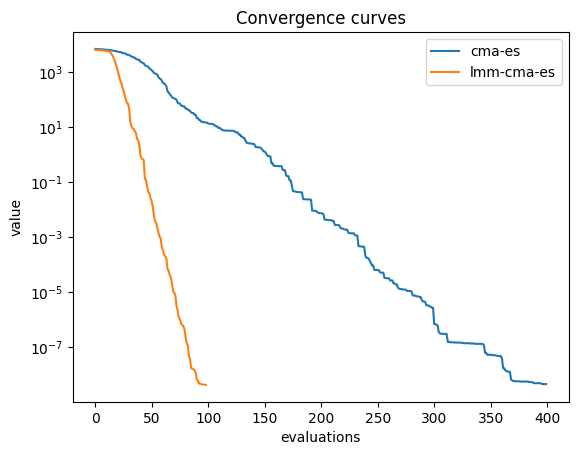

In [10]:
from optilab.plotting import plot_box_plot, plot_convergence_curve, plot_ecdf_curves

# plot convergence curve for the two optimizers
plot_convergence_curve({run.model_metadata.name: run.logs for run in [cmaes_runs, lmm_cmaes_runs]})

As you can see the LMM-CMA-ES converges much quicker than regular CMA-ES. Now let's plot the ECDF curve:

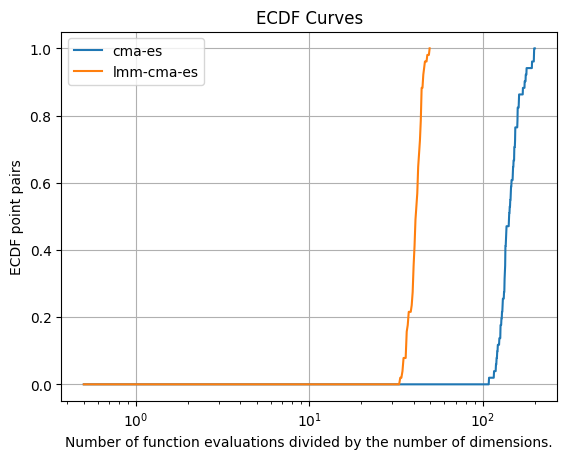

In [11]:
plot_ecdf_curves({run.model_metadata.name: run.logs for run in [cmaes_runs, lmm_cmaes_runs]}, DIM, TOLERANCE)

Lastly, let's plot the box plot of optimization results:

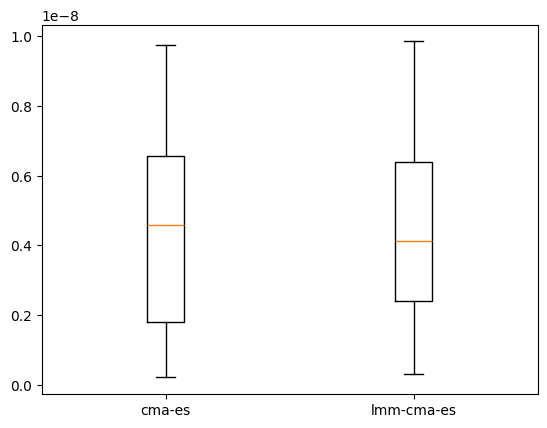

In [12]:
plot_box_plot(data={run.model_metadata.name: run.bests_y() for run in [cmaes_runs, lmm_cmaes_runs]})

Plotting functions also alow for saving the plots to an image file. Use keyword argument `savepath=` to specify where to save the image.

## Save results to a pickle file and analyze it using optilab's CLI tool
To save the results of an experiment you can dump optimization runs to a pickle file and then read it and plot is using optilab's CLI functionality. Firstly, pack all OptimizationRun objects into a list. Then use a utility function to save it to a pickle file.

In [13]:
from optilab.utils import dump_to_pickle

runs = [cmaes_runs, lmm_cmaes_runs]

SAVEFILE_NAME = 'tutorial.pkl'

dump_to_pickle(runs, SAVEFILE_NAME)

Now that you saved the results to a pickle file, you can read it into the CLI tool to get various information about the results. The CLI tool also allows to perform statistical testing on the results to determine if the difference in results is statistically significant.

In [ ]:
!optilab $SAVEFILE_NAME --test_y --test_eval

# File tutorial.pkl
Figure(640x480)
Figure(640x480)
Figure(640x480)
|    | model      | function   |   runs |   dim |   popsize | bounds   |   tolerance |
|----|------------|------------|--------|-------|-----------|----------|-------------|
|  0 | cma-es     | sphere     |     51 |     2 |         4 | -100 100 |       1e-08 |
|  1 | lmm-cma-es | sphere     |     51 |     2 |         4 | -100 100 |       1e-08 | 

|    |       y_min |       y_max |      y_mean |       y_std |    y_median |       y_iqr |
|----|-------------|-------------|-------------|-------------|-------------|-------------|
|  0 | 2.03327e-10 | 9.74329e-09 | 4.6452e-09  | 2.97277e-09 | 4.59554e-09 | 4.7739e-09  |
|  1 | 3.16116e-10 | 9.85303e-09 | 4.34819e-09 | 2.68483e-09 | 4.11367e-09 | 3.99832e-09 | 

|    |   evals_min |   evals_max |   evals_mean |   evals_std |
|----|-------------|-------------|--------------|-------------|
|  0 |         220 |         400 |      292.706 |    40.388   |
|  1 |          67 |    

## Closing remarks
Thank you for choosing optilab for your project. If you wish to learn more checkout the projects repo on [github](https://github.com/mlojek/optilab) and the project's documentation on [readthedocs](https://optilab.readthedocs.io). Feel free to use optilab in your research and work. If you wish to contribute to the project, feel free to do so yourself or leave an issue in the repo. Best of luck, Marcin.